Building a First Model

    - In the last notebook, we loaded in the data from retrosheet and did some processing to get the team level statistics.

    - We saved that data to a file called 'df_bp1.csv'

    - In this notebook, we will load in that data, do some initital data exploration, and then build and evaluate our first predictive model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli

from structureboost import log_loss
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
df = pd.read_csv('df_bp1.csv', low_memory=False)

Data Checks/Exploration

In [3]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116082 entries, 0 to 116081
Data columns (total 194 columns):
 #    Column                Non-Null Count   Dtype  
---   ------                --------------   -----  
 0    date                  116082 non-null  int64  
 1    dblheader_code        116082 non-null  int64  
 2    day_of_week           116082 non-null  object 
 3    team_v                116082 non-null  object 
 4    league_v              116082 non-null  object 
 5    game_no_v             116082 non-null  int64  
 6    team_h                116082 non-null  object 
 7    league_h              116082 non-null  object 
 8    game_no_h             116082 non-null  int64  
 9    runs_v                116082 non-null  int64  
 10   runs_h                116082 non-null  int64  
 11   outs_total            116082 non-null  int64  
 12   day_night             116082 non-null  object 
 13   completion_info       116 non-null     object 
 14   forfeit_info          5 non-null  

In [4]:
df.season.value_counts().sort_index()

1970    1944
1971    1938
1972    1859
1973    1943
1974    1945
1975    1934
1976    1939
1977    2103
1978    2102
1979    2099
1980    2105
1981    1394
1982    2107
1983    2109
1984    2105
1985    2103
1986    2103
1987    2105
1988    2100
1989    2106
1990    2105
1991    2104
1992    2106
1993    2269
1994    1600
1995    2017
1996    2267
1997    2266
1998    2432
1999    2428
2000    2429
2001    2429
2002    2426
2003    2430
2004    2428
2005    2431
2006    2429
2007    2431
2008    2428
2009    2430
2010    2430
2011    2429
2012    2430
2013    2431
2014    2430
2015    2429
2016    2428
2017    2430
2018    2431
2019    2429
2020     898
2021    2429
2022    2430
Name: season, dtype: int64

In [5]:
hv_mean = df.home_victory.mean()
hv_mean

0.5382057511069761

In [6]:
df.run_diff.value_counts()

 1     20722
-1     13459
 2     10857
-2     10580
 3      8601
-3      8344
 4      6690
-4      6457
 5      4836
-5      4662
 6      3514
-6      3294
 7      2380
-7      2364
 8      1746
-8      1553
 9      1159
-9      1019
 10      761
-10      689
 11      470
-11      432
 12      299
-12      268
 13      183
-13      180
-14      111
 14      109
 15       60
-15       53
 0        48
-16       43
 16       38
 17       22
-17       17
-18       13
 19       10
 18        9
-19        8
 21        6
-21        4
-22        3
-20        3
 20        3
 22        1
-27        1
-23        1
Name: run_diff, dtype: int64

In [7]:
df.outs_total.value_counts()

51     52478
54     48269
53      2266
60      2264
52      1990
66      1259
58      1055
59       972
72       681
64       537
65       526
57       501
78       370
70       294
71       285
63       261
84       211
77       172
76       149
42       132
39       131
69       129
83       104
90       104
82        92
75        83
89        58
96        56
36        46
30        38
48        35
33        33
81        32
102       31
88        30
45        28
95        27
94        24
108       21
31        19
41        19
40        19
100       16
101       14
87        14
93        13
46        13
43        12
32        11
34        11
106       10
114       10
28        10
27        10
38        10
37         9
44         8
105        7
29         7
47         6
120        6
107        6
113        5
111        5
49         5
50         4
118        4
126        4
112        3
132        3
35         3
99         2
125        1
73         1
150        1
119        1
0          1

In [8]:
df.home_victory[df.outs_total==53].mean()

0.998676081200353

In [9]:
df.loc[(df.outs_total==53) & (df.home_victory!=1),:]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v
354,19700512,0,Tue,NYA,AL,33,MIL,AL,32,9,5,53,N,NaN,NaN,NaN,MIL05,5382.0,150.0,100232010,000000041,34.0,10.0,1.0,1.0,0.0,7.0,2.0,1.0,0.0,5.0,2.0,5.0,1.0,0.0,1.0,0.0,6.0,2.0,5.0,5.0,0.0,0.0,26.0,11.0,2.0,1.0,1.0,0.0,40.0,12.0,3.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,9.0,4.0,4.0,4.0,0.0,0.0,27.0,12.0,3.0,0.0,1.0,0.0,barnl901,Larry Barnett,nappl901,Larry Napp,ricej901,John Rice,sprim901,Marty Springstead,NaN,(none),NaN,(none),houkr101,Ralph Houk,brisd801,Dave Bristol,petef101,Fritz Peterson,kraul102,Lew Krausse,mcdal101,Lindy McDaniel,whitr101,Roy White,petef101,Fritz Peterson,kraul102,Lew Krausse,clarh101,Horace Clarke,4.0,kennj103,Jerry Kenney,5.0,murcb101,Bobby Murcer,8.0,whitr101,Roy White,7.0,cated101,Danny Cater,3.0,blefc101,Curt Blefary,9.0,michg101,Gene Michael,6.0,gibbj101,Jake Gibbs,2.0,petef101,Fritz Peterson,1.0,harpt101,Tommy Harper,5.0,hegam101,Mike Hegan,3.0,savat101,Ted Savage,9.0,waltd101,Danny Walton,7.0,alleh104,Hank Allen,8.0,kubit101,Ted Kubiak,6.0,kennj105,John Kennedy,4.0,roofp101,Phil Roof,2.0,kraul102,Lew Krausse,1.0,NaN,Y,1970,-4,0,14,197005120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250992,0.241983,0.329485,0.335038,0.364087,0.342080,0.693572,0.677118,27.0,19.0,13.0,13.0,36.0,26.0
8279,19740604,0,Tue,TEX,AL,51,CLE,AL,50,5,5,53,N,NaN,V,NaN,CLE07,25134.0,185.0,011102000,000102002,34.0,9.0,4.0,1.0,2.0,5.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,1.0,1.0,0.0,7.0,2.0,3.0,3.0,0.0,0.0,26.0,8.0,1.0,0.0,2.0,0.0,36.0,12.0,2.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,6.0,4.0,5.0,5.0,0.0,0.0,27.0,9.0,0.0,0.0,1.0,0.0,mccol901,Larry McCoy,brinj901,Joe Brinkman,bremn901,Nick Bremigan,chyln901,Nestor Chylak,NaN,(none),NaN,(none),martb105,Billy Martin,asprk101,Ken Aspromonte,NaN,NaN,NaN,NaN,NaN,(none),NaN,(none),jenkf101,Fergie Jenkins,petef101,Fritz Peterson,tovac101,Cesar Tovar,8.0,randl101,Lenny Randle,4.0,johna104,Alex Johnson,7.0,burrj001,Jeff Burroughs,9.0,griet101,Tom Grieve,10.0,fregj101,Jim Fregosi,3.0,harrt001,Toby Harrah

In [10]:
df.game_no_h.value_counts().sort_index()

1      735
2      734
3      738
4      734
5      732
6      738
7      738
8      741
9      751
10     743
11     731
12     725
13     737
14     734
15     735
16     737
17     744
18     756
19     756
20     732
21     718
22     743
23     741
24     733
25     718
26     723
27     735
28     730
29     736
30     740
31     762
32     762
33     749
34     755
35     739
36     723
37     709
38     705
39     714
40     728
41     752
42     756
43     747
44     746
45     753
46     750
47     736
48     725
49     721
50     725
51     717
52     730
53     728
54     734
55     742
56     726
57     735
58     741
59     766
60     771
61     726
62     714
63     715
64     711
65     722
66     736
67     721
68     710
69     724
70     721
71     719
72     719
73     722
74     715
75     726
76     752
77     743
78     723
79     734
80     712
81     715
82     711
83     704
84     723
85     712
86     722
87     706
88     704
89     727
90     707
91     726

In [11]:
df[df.runs_v==df.runs_h]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v
346,19700511,0,Mon,NYA,AL,32,MIL,AL,31,5,5,54,N,NaN,NaN,NaN,MIL05,4822.0,183.0,0001000130,003000110x,35.0,7.0,1.0,1.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,10.0,3.0,2.0,2.0,1.0,0.0,27.0,19.0,2.0,0.0,3.0,0.0,34.0,10.0,2.0,0.0,1.0,2.0,1.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,2.0,0.0,6.0,5.0,2.0,2.0,0.0,0.0,27.0,9.0,2.0,0.0,0.0,0.0,sprim901,Marty Springstead,barnl901,Larry Barnett,nappl901,Larry Napp,ricej901,John Rice,NaN,(none),NaN,(none),houkr101,Ralph Houk,brisd801,Dave Bristol,NaN,NaN,NaN,NaN,NaN,(none),NaN,(none),stotm101,Mel Stottlemyre,bolib101,Bobby Bolin,clarh101,Horace Clarke,4.0,kennj103,Jerry Kenney,5.0,murcb101,Bobby Murcer,8.0,whitr101,Roy White,7.0,cated101,Danny Cater,3.0,blefc101,Curt Blefary,9.0,munst101,Thurman Munson,2.0,michg101,Gene Michael,6.0,stotm101,Mel Stottlemyre,1.0,harpt101,Tommy Harper,5.0,snydr102,Russ Snyder,8.0,hegam101,Mike Hegan,3.0,waltd101,Danny Walton,7.0,hovls101,Steve Hovley,9.0,kubit101,Ted Kubiak,6.0,kennj105,John Kennedy,4.0,roofp101,Phil Roof,2.0,bolib101,Bobby Bolin,1.0,NaN,Y,1970,0,0,10,197005110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245771,0.241447,0.325623,0.333906,0.355224,0.345064,0.680847,0.678969,25.0,20.0,13.0,13.0,36.0,25.0
2206,19710501,0,Sat,MON,NL,16,SLN,NL,25,2,2,42,N,NaN,NaN,NaN,STL09,32061.0,82.0,1000010,0200000,26.0,7.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,0.0,6.0,1.0,2.0,2.0,0.0,0.0,21.0,4.0,0.0,0.0,0.0,0.0,23.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,21.0,5.0,0.0,1.0,1.0,0.0,steim901,Mel Steiner,engeb901,Bob Engel,venzt901,Tony Venzon,lands901,Stan Landes,NaN,(none),NaN,(none),maucg101,Gene Mauch,schor101,Red Schoendienst,NaN,NaN,NaN,NaN,NaN,(none),NaN,(none),renks101,Steve Renko,gibsb101,Bob Gibson,bailb103,Bob Bailey,5.0,huntr101,Ron Hunt,4.0,staur001,Rusty Staub,9.0,fairr101,Ron Fairly,3.0,fairj102,Jim Fairey,7.0,day-b102,Boots Day,8.0,batej102,John Bateman,2.0,wineb101,Bobby Wine,6.0,renks101,Steve Renko,1.0,brocl102,Lou Broc

BEGIN MODELING

In [26]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1970) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [27]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [28]:
X_train.shape, X_valid.shape, X_test.shape, 

((98617, 4), (10615, 4), (4859, 4))

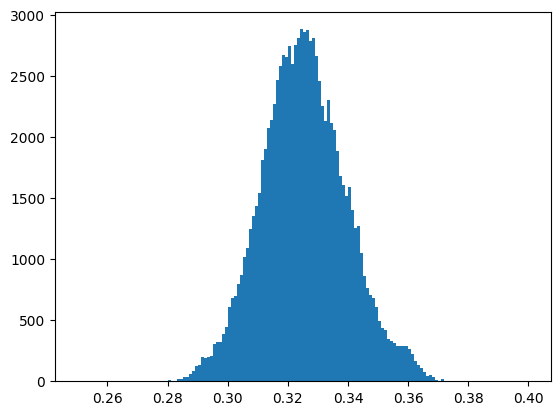

In [29]:
plt.hist(X_train.OBP_162_h, np.linspace(.25,.4,151));

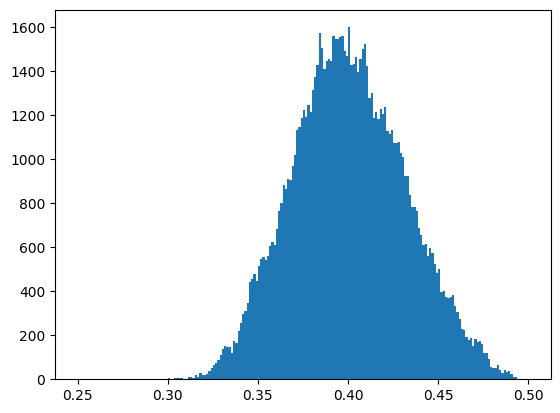

In [30]:
plt.hist(X_train.SLG_162_v, np.linspace(.25,.5,201));

In [31]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.6899
[20]	valid_0's binary_logloss: 0.689204
[30]	valid_0's binary_logloss: 0.688683
[40]	valid_0's binary_logloss: 0.688271
[50]	valid_0's binary_logloss: 0.68781
[60]	valid_0's binary_logloss: 0.687463
[70]	valid_0's binary_logloss: 0.687158
[80]	valid_0's binary_logloss: 0.686843
[90]	valid_0's binary_logloss: 0.686558
[100]	valid_0's binary_logloss: 0.686336
[110]	valid_0's binary_logloss: 0.686152
[120]	valid_0's binary_logloss: 0.686012
[130]	valid_0's binary_logloss: 0.685872
[140]	valid_0's binary_logloss: 0.685756
[150]	valid_0's binary_logloss: 0.685683
[160]	valid_0's binary_logloss: 0.685578
[170]	valid_0's binary_logloss: 0.68551
[180]	valid_0's binary_logloss: 0.685453
[190]	valid_0's binary_logloss: 0.68539
[200]	valid_0's binary_logloss: 0.685347
[210]	valid_0's binary_logloss: 0.685315
[220]	valid_0's binary_logloss: 0.685286
[230]	valid_0's binary_logloss: 0.685263
[240]	vali

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [32]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6837740579507787, 0.6905445705936595)

In [33]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

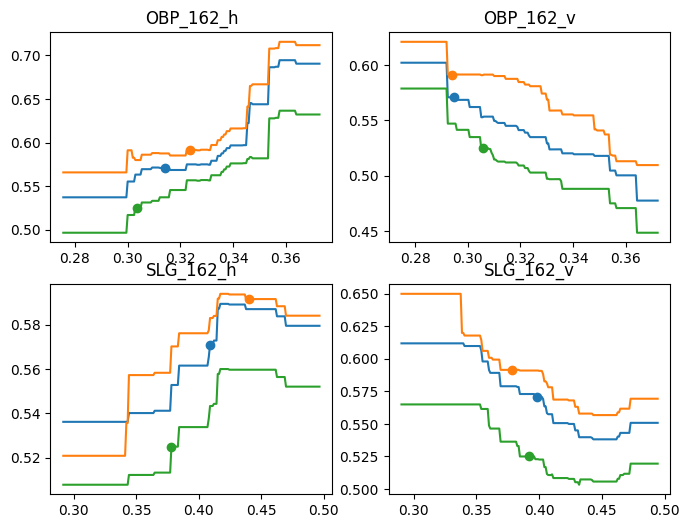

In [34]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=2)

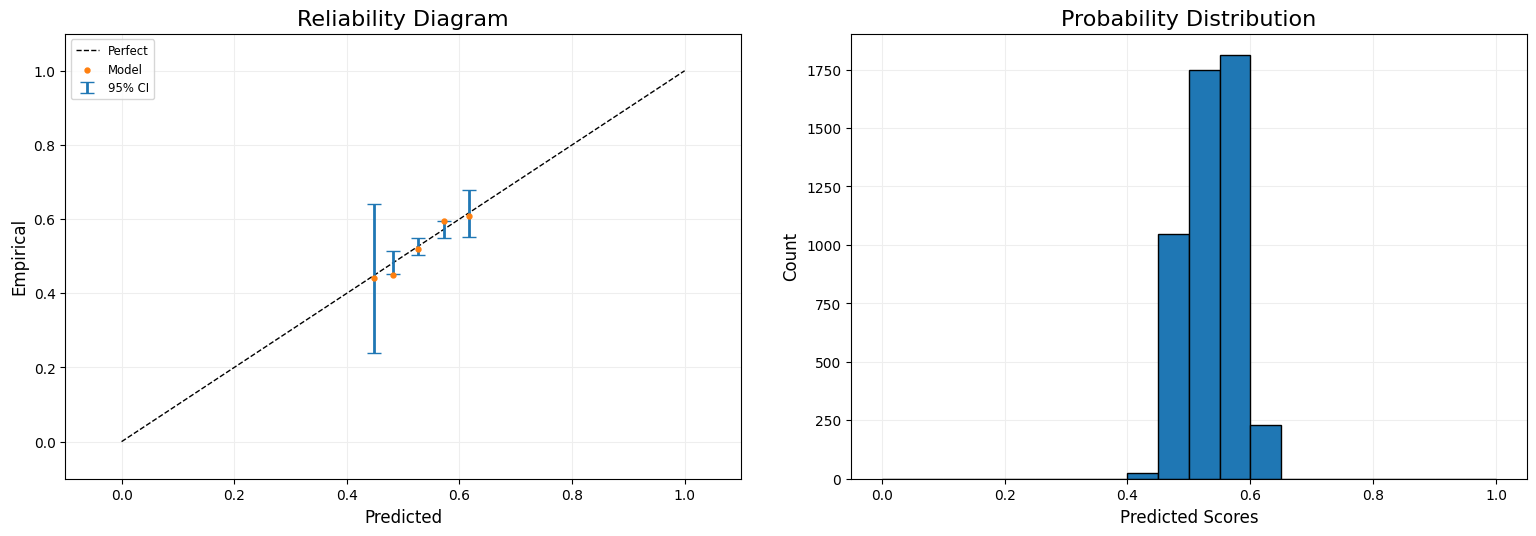

In [35]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [36]:
fc = stb.get_basic_config(X_train, stb.default_config_dict())

stb1 = stb.StructureBoost(max_depth=3, learning_rate=.02, feature_configs = fc, num_trees=2000)
stb1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5)

i=0, eval_set_loss = 0.6908893928987648
i=10, eval_set_loss = 0.6898982610109209
i=20, eval_set_loss = 0.688937463165018
i=30, eval_set_loss = 0.6883577728668399
i=40, eval_set_loss = 0.6878213636308722
i=50, eval_set_loss = 0.6873926602011069
i=60, eval_set_loss = 0.6872585314942294
i=70, eval_set_loss = 0.6870588992829715
i=80, eval_set_loss = 0.6866958727747278
i=90, eval_set_loss = 0.6862478060594286
i=100, eval_set_loss = 0.6861252638189692
i=110, eval_set_loss = 0.6859300890109471
i=120, eval_set_loss = 0.6858654778199949
i=130, eval_set_loss = 0.6857849571548746
i=140, eval_set_loss = 0.6855480260201506
i=150, eval_set_loss = 0.6855180812140632
i=160, eval_set_loss = 0.6853770426180988
i=170, eval_set_loss = 0.685262704487064
i=180, eval_set_loss = 0.6852503504130458
i=190, eval_set_loss = 0.6851070251989451
i=200, eval_set_loss = 0.6849953682366072
i=210, eval_set_loss = 0.6849018387627379
i=220, eval_set_loss = 0.6849284987825676
i=230, eval_set_loss = 0.6847905242443928
i=240

In [37]:
preds_stb = stb1.predict(X_test)
log_loss(y_test, preds_stb), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6842217252611464, 0.6905445705936595)

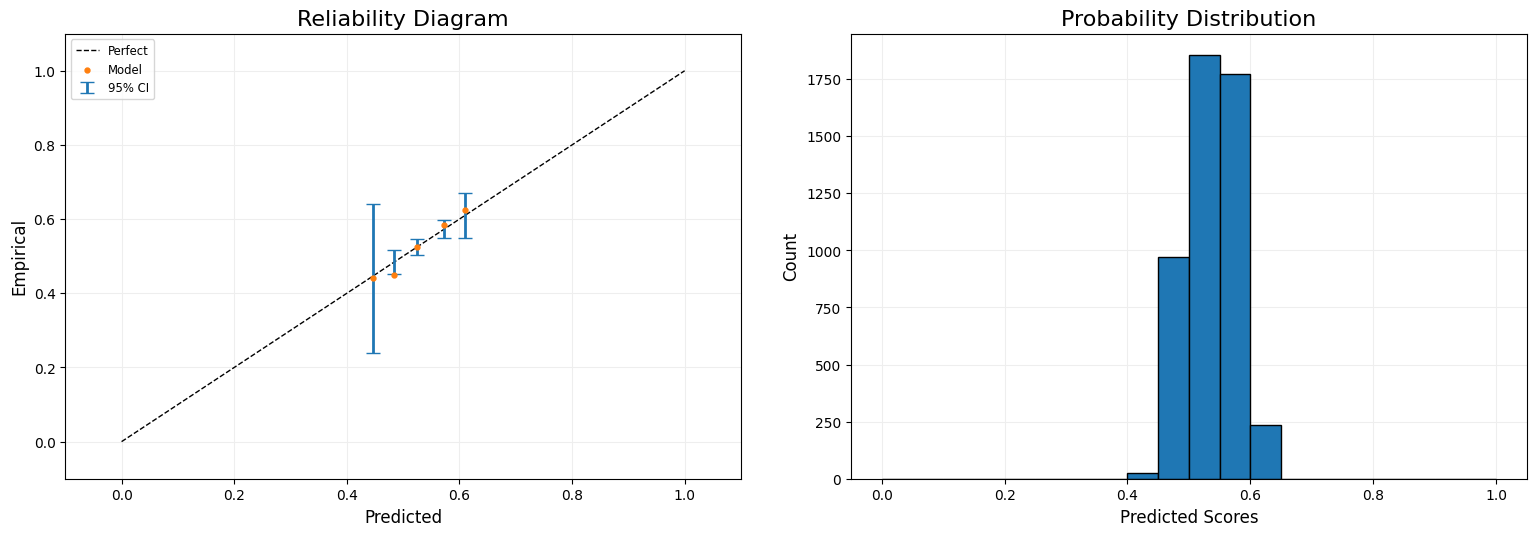

In [38]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_stb, show_histogram=True);

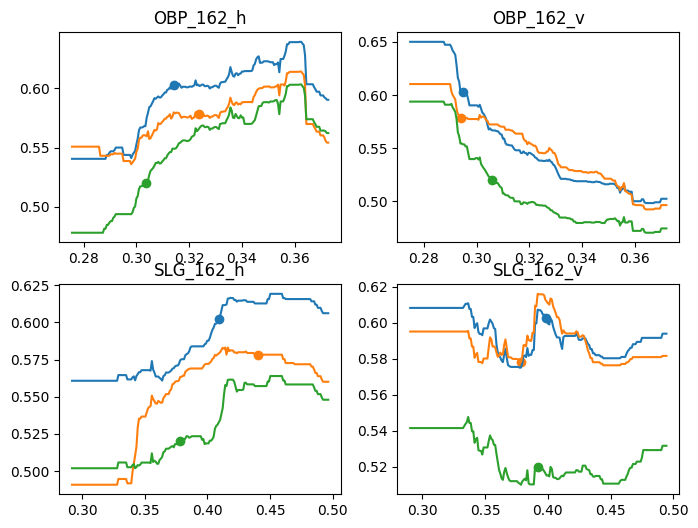

In [39]:
rd= mli.get_range_dict(X_train)
mli.ice_plot(stb1, plot_pts, X_test.columns, rd, plots_per_row=2)